# Loan Application Status Prediction

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv('loan_prediction.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


from the above we can see that we have 614 rows and 13 columns in our dataset. loan status is our target/label as instruction and rest of column are our feature.

# Exploratory Data Analysis (EDA)

In [3]:
df.shape

(614, 13)

In [4]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


from the above info method we can see that our dataset is having three kind of data  namely object, int64, and float64. 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


we have look used describe.transpose method to look the missing value as well as outlier present in dataset. As far as we can see that there must be some missing vlaue in some of columns and outlier too present in dataset.

In [7]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<AxesSubplot:>

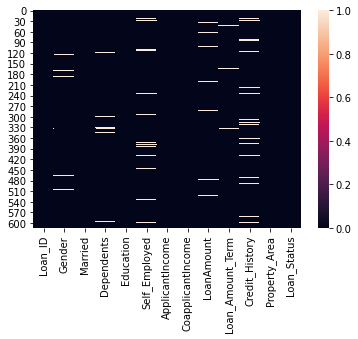

In [8]:
sns.heatmap(df.isnull())

there are so many columns having missing values they need to be treated as per requirement . 

In [9]:
df.nunique().to_frame('unique values')

,unique values
Loan_ID,614
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10


from the above unique value method we can see Loan_ID in our dataset is no mean to keep as their unique value is equal to total no of rows . we need to drop it now .

In [10]:
df.drop('Loan_ID',axis=1, inplace=True)
df.shape

(614, 12)

In [11]:
#object datatypes
object_datatypes=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='O':
      object_datatypes.append(x)
print('object datatype = ',object_datatypes)    
    
    
#number_datatyped
number_datatypes=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='float64' or df.dtypes[x]=='int64':
        number_datatypes.append(x)
print('number datatype = ',number_datatypes)        

object datatype =  ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
number datatype =  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


Great , we have catogarize our columns as per their type . now we have considered that our dataset is only two type object and number type. now it's been is for removing the outlier and skewness from our dataset.

In [12]:
for col in object_datatypes:
    print(col)
    print(df[col].value_counts())
    print("="*120)

Gender
Male      489
Female    112
Name: Gender, dtype: int64
Married
Yes    398
No     213
Name: Married, dtype: int64
Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64


# Fill the missing value

In [13]:
#filling the Missing value with mean if data is continous 
df['LoanAmount']=df['LoanAmount'].fillna(df['LoanAmount'].mean())

#filling the missing value with mode if data are catagorical
df['Gender']=df['Gender'].fillna(df['Gender'].mode()[0])
df['Married']=df['Married'].fillna(df['Married'].mode()[0])
df['Dependents']=df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Loan_Amount_Term']=df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Self_Employed']=df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])


In [14]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Visualization

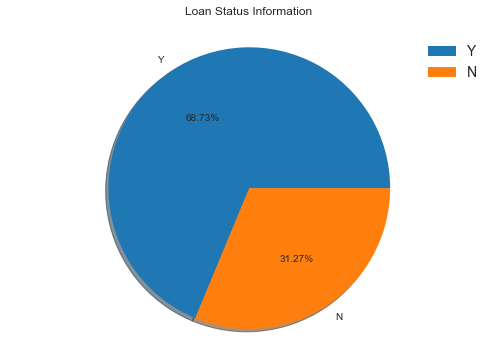

In [15]:
plt.style.use('seaborn-white')
plt.figure(figsize=(7,5))
plt.pie(df['Loan_Status'].value_counts(), labels=df['Loan_Status'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Loan Status Information\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

from the above pie chart graph we can see that approved loan is 68.73% and 31.27 is rejected .so, our class is imbalance and we have to treat our target label befor model building 

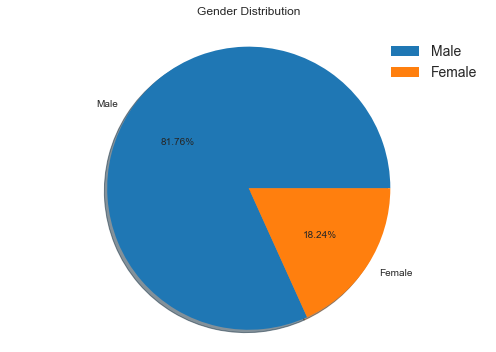

In [16]:
plt.figure(figsize=(7,5))
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Gender Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

from the above pie chart we can see that 81.36% are males and only 18.64% are female for the loan.

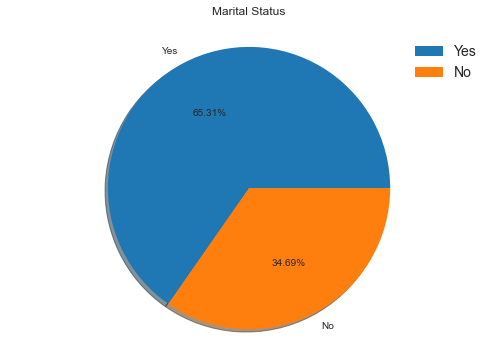

In [17]:
plt.figure(figsize=(7,5))
plt.pie(df['Married'].value_counts(), labels=df['Married'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Marital Status\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

from the above plot we can see that 65.14% people are married who needs loan and only 34.86% are unmarried.

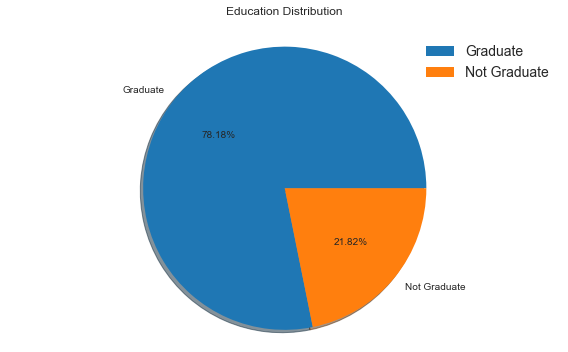

In [18]:
plt.figure(figsize=(8,5))
plt.pie(df['Education'].value_counts(), labels=df['Education'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Education Distribution\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()


from the above plot we can say that 78.18 % are Graduate and only 21.82% are undergraduate .

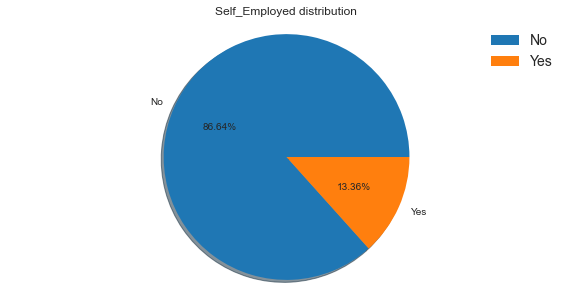

In [19]:
plt.figure(figsize=(10,5))
plt.pie(df['Self_Employed'].value_counts(),labels=df['Self_Employed'].value_counts().index,shadow=True,autopct='%1.2f%%')
plt.title('Self_Employed distribution')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.show()

from the above pie chart distribution we can say that most of the people are unemployed who has applied for the loan.

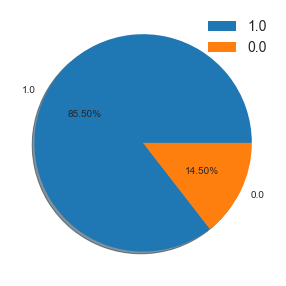

In [20]:
plt.figure(figsize=(10,5))
plt.pie(df['Credit_History'].value_counts(),labels=df['Credit_History'].value_counts().index,
        shadow=True, autopct='%1.2f%%')
plt.title=('Credit History Details')
plt.legend(prop={'size':14})
plt.show()

in the above pir chart we can see that 1.0 is showing that we have history details and 0.0 showing we have no any history detail.means we have the record of 84.22% people of past loan  and only 15.78% people are i think new.

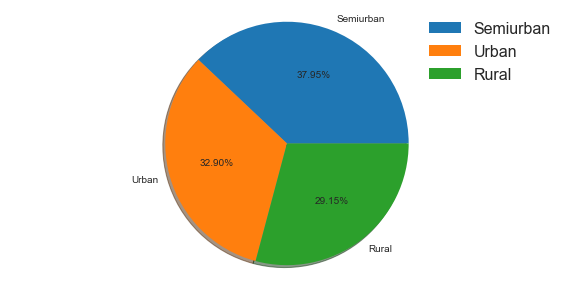

In [21]:
plt.figure(figsize=(10,5))
plt.pie(df['Property_Area'].value_counts(),labels=df['Property_Area'].value_counts().index,
       shadow=True, autopct='%1.2f%%')
plt.title=('Property_Area Distribution')
plt.legend(prop={'size':16})
plt.axis('equal')
plt.show()

the above plot is displaying that 37.95% loan Aspirant belongs to Semiurban region, 32.90% belongs to Urban and 29.15 belongs to Rural Region .

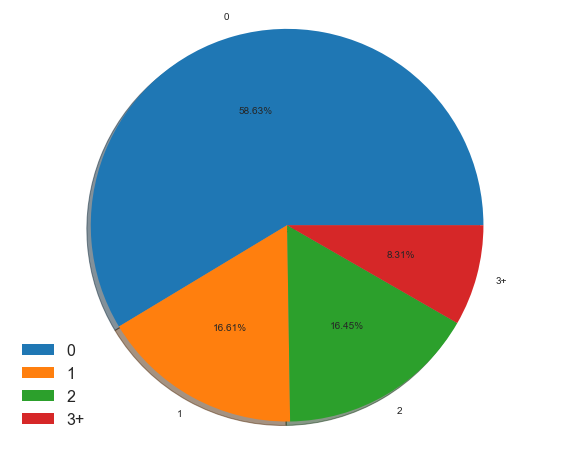

In [22]:
plt.figure(figsize=(10,8))
plt.pie(df['Dependents'].value_counts(),labels=df['Dependents'].value_counts().index,
       shadow=True, autopct='%1.2f%%') 
plt.title=('Dependents distributor')
plt.legend(prop={'size':16})
plt.axis('equal')
plt.show()           
           
           

from the above graph it is clear that 57.60% people has 0 dependence ,8.51% has 3 dependent, 16.86 has 2 dependent and 17.03 has 1 dependent

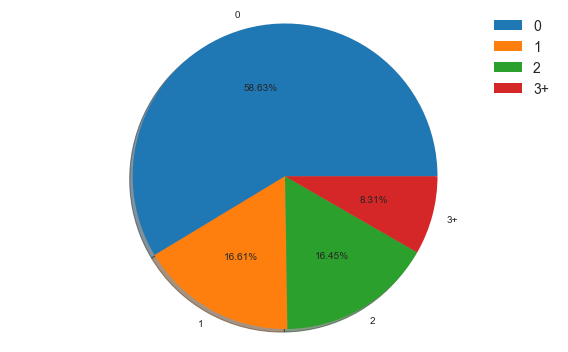

In [23]:
plt.figure(figsize=(8,5))
plt.pie(df['Dependents'].value_counts(), labels=df['Dependents'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title=('Information on number of Dependents\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()


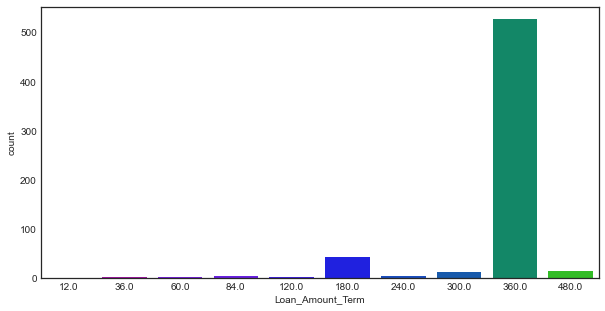

In [24]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

from the above plot we can see that most of area are covered by value 360.0 in column 'Loan_Amount_term'

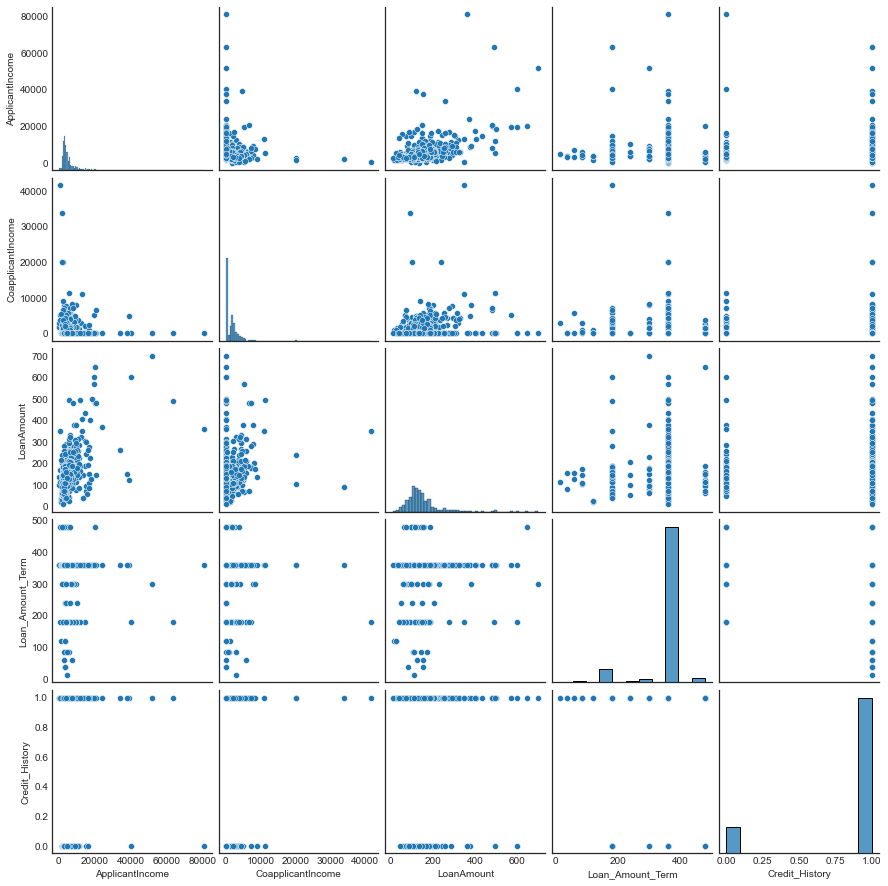

In [25]:
sns.pairplot(df)
plt.show()

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

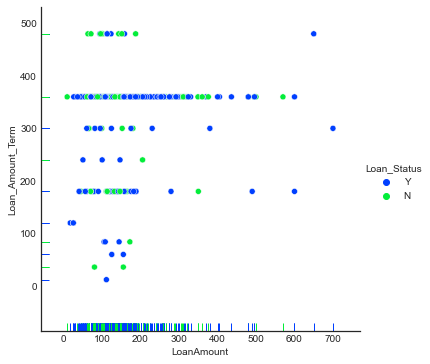

In [26]:
plt.style.use('seaborn-bright')
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

from the above LoanAmount and Loan_Amount_term graph we can see that most loan applicant belongs to 300 and to 400 and most of them have loan_status already 

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

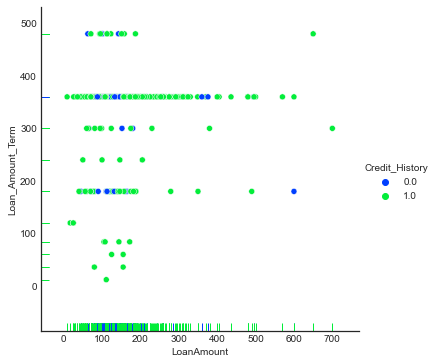

In [27]:
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

from the above plot we can see that most of applicant has credit_history

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

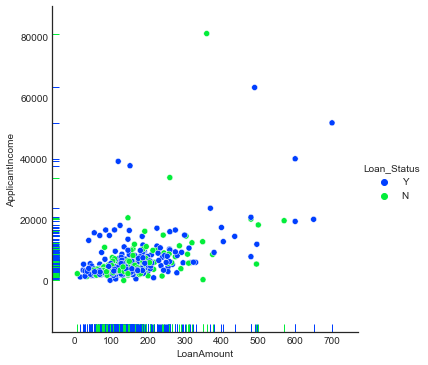

In [28]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)

from the above  we can see that most of Applicant whose LoanAmount is inthe range of 0 to 300 has Income between 0 to 20000

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

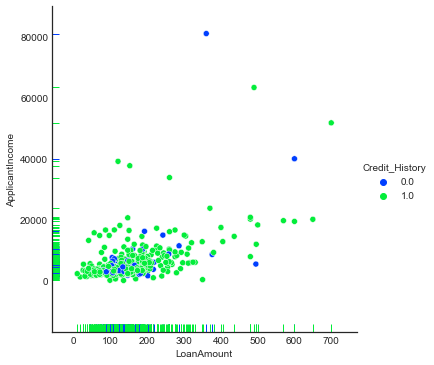

In [29]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

Above plot is displaying that range of income 0 to 20000 and LoanAmount range 0 to 400 is having credit history mostly.

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

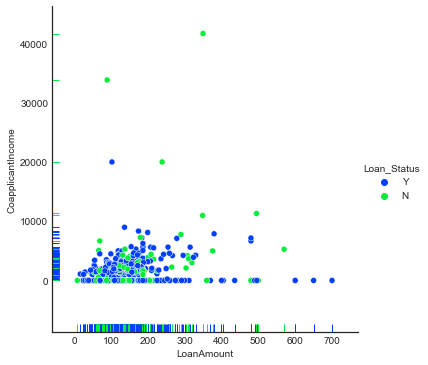

In [30]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

above plot is displaying that range of 0 to 400 many have got the loan and many got rejection

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

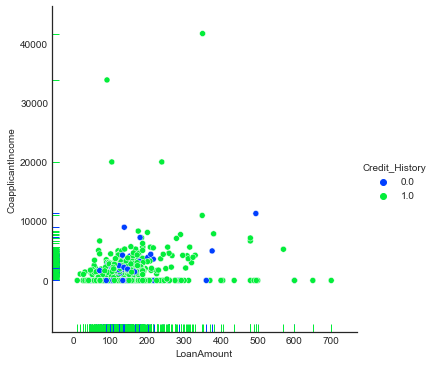

In [31]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

from the above plot we have seen that most of applicant who has applied for loan has credit history .

# Encoding the catagorical object dataype columns

In [32]:
#labelEncoder
le=LabelEncoder()
df['Loan_Status']=le.fit_transform(df["Loan_Status"])

In [33]:
#ordinal Endocer

oe = OrdinalEncoder()
df['Gender'] = oe.fit_transform(df['Gender'].values.reshape(-1,1))
df['Married'] = oe.fit_transform(df['Married'].values.reshape(-1,1))
df['Dependents'] = oe.fit_transform(df['Dependents'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Self_Employed'] = oe.fit_transform(df['Self_Employed'].values.reshape(-1,1))
df['Property_Area'] = oe.fit_transform(df['Property_Area'].values.reshape(-1,1))
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


# Boxplot

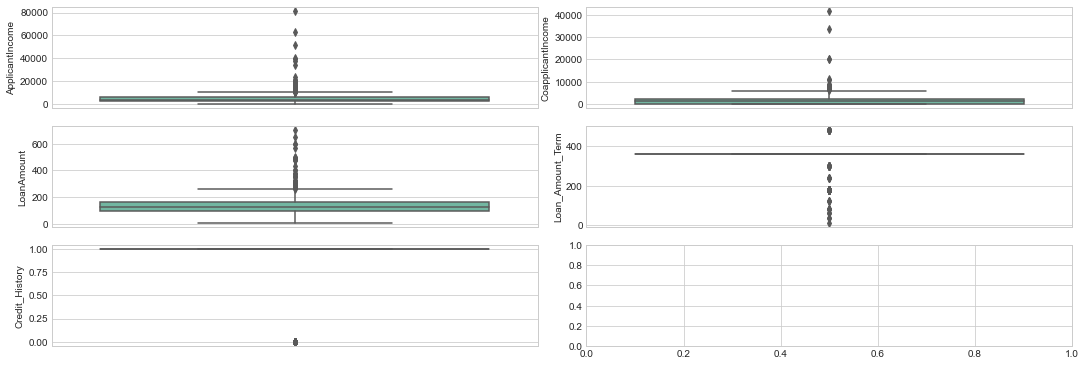

In [34]:
plt.style.use('seaborn-whitegrid')
fig, ax=plt.subplots(ncols=2, nrows=3 , figsize=(15,5))
index=0
ax=ax.flatten()
for col, value in df[number_datatypes].items():
    sns.boxplot(y=col, data=df, ax=ax[index],palette='Set2')
    
    index += 1
    
plt.tight_layout(pad=.4, w_pad=.4, h_pad=1)
plt.show()
    


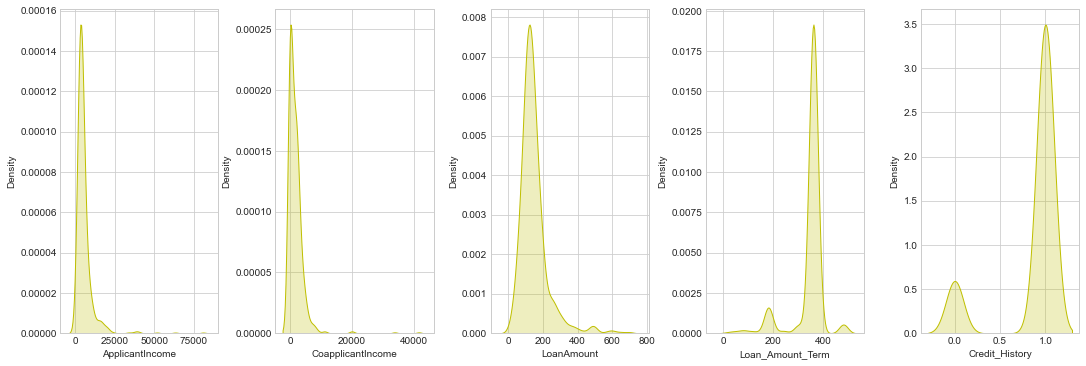

In [35]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatypes].items():
    sns.distplot(value, ax=ax[index], hist=False, color="y", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()


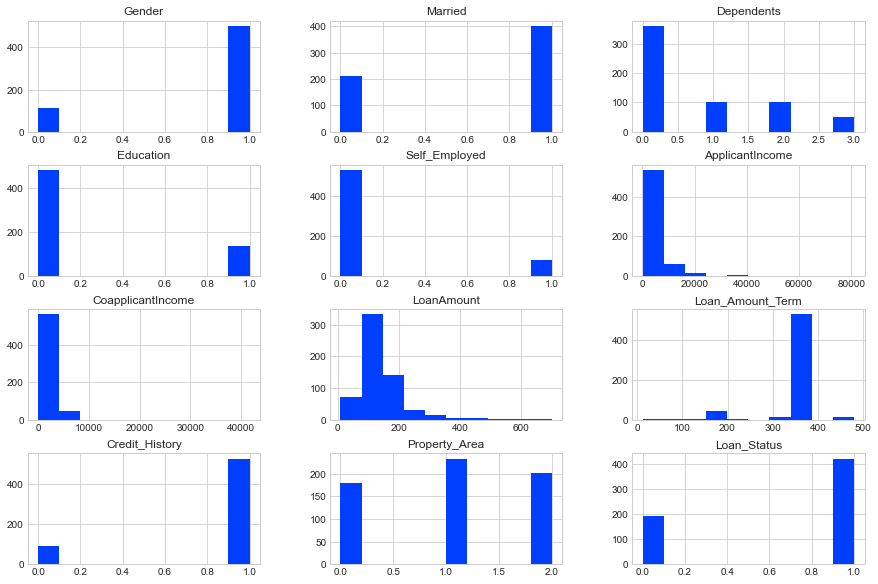

In [36]:
df.hist(figsize=(15,10))
plt.show()

# Correlation using a Heatmap
Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

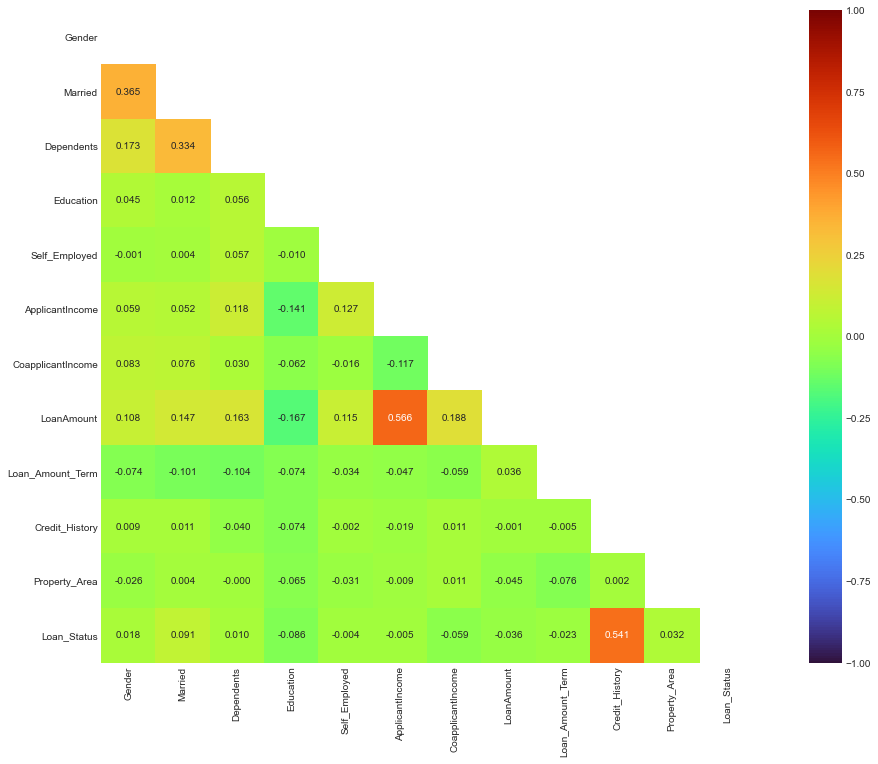

In [37]:
plt.style.use('seaborn-pastel')
upper_triangle=np.triu(df.corr())
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='.3f',
           annot_kws={'size':10}, cmap='turbo', mask=upper_triangle)



plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

from the above graph we can see that there is no chances of multicollearnity .

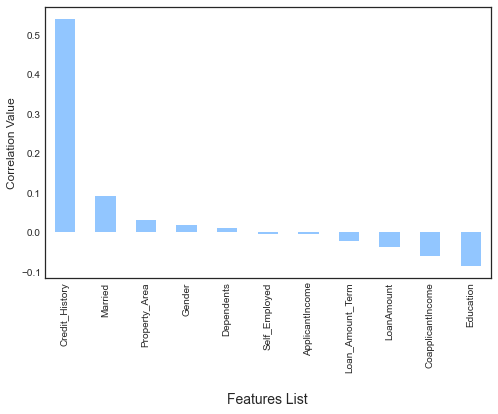

In [38]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(8,5))
df_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

# Using Zscore to remove out the outliers 

In [39]:
z=np.abs(zscore(df))
threashold=3
df1=df[(z<3).all(axis=1)]
loss=(df.shape[0]-df1.shape[0])/df.shape[0]*100
loss

6.026058631921824

i have used Zscore mehtod to remove the outlier which was earlier present in our dataset and in this way we have lost 6% data than can be affoded.

In [40]:
df.skew()

Gender              -1.648795
Married             -0.644850
Dependents           1.015551
Education            1.367622
Self_Employed        2.159796
ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.726601
Loan_Amount_Term    -2.402112
Credit_History      -2.021971
Property_Area       -0.066196
Loan_Status         -0.809998
dtype: float64

# Using Log Transformaation method to fix the skewness

In [41]:
for col in number_datatypes:
    if df.skew().loc[col]>.55:
        df[col]=np.log1p(df[col])

In [42]:
df.skew()

Gender              -1.648795
Married             -0.644850
Dependents           1.015551
Education            1.367622
Self_Employed        2.159796
ApplicantIncome      0.482128
CoapplicantIncome   -0.173073
LoanAmount          -0.179713
Loan_Amount_Term    -2.402112
Credit_History      -2.021971
Property_Area       -0.066196
Loan_Status         -0.809998
dtype: float64

# splitting data into two parts namely X and Y

In [43]:
X=df.drop('Loan_Status', axis=1)
Y=df['Loan_Status']

In [44]:
Y.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

from above count method telling that our target or label is imbalanced , before building the model we need to deal with it first.

In [45]:
sm=SMOTE()
X,Y= sm.fit_resample(X,Y)

In [46]:
Y.value_counts()

0    422
1    422
Name: Loan_Status, dtype: int64

now it's been perfect 

# Feature Scaling

In [47]:
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.481362,-1.341149,-0.722601,-0.549114,-0.400855,0.551280,-1.056957,0.272157,0.247535,0.580893,1.221308
1,0.481362,0.769146,0.292888,-0.549114,-0.400855,0.151304,0.827219,-0.019916,0.247535,0.580893,-1.324826
2,0.481362,0.769146,-0.722601,-0.549114,2.635809,-0.543495,-1.056957,-1.454057,0.247535,0.580893,1.221308
3,0.481362,0.769146,-0.722601,1.905757,-0.400855,-0.788869,0.942236,-0.160068,0.247535,0.580893,1.221308
4,0.481362,-1.341149,-0.722601,-0.549114,-0.400855,0.593077,-1.056957,0.190272,0.247535,0.580893,1.221308
...,...,...,...,...,...,...,...,...,...,...,...
839,0.481362,0.769146,0.616627,-0.549114,-0.400855,-0.226501,0.948039,0.655774,0.247535,0.580893,-0.457616
840,0.481362,0.769146,-0.056597,-0.549114,1.590729,1.840523,-1.056957,0.353454,0.247535,0.580893,-1.324826
841,0.481362,0.769146,1.178299,-0.549114,-0.400855,0.287770,0.899683,0.678548,0.247535,0.580893,-1.324826
842,0.481362,0.769146,-0.722601,-0.549114,-0.400855,-0.313105,0.938855,0.135804,0.247535,-0.515416,1.221308


we have used StandardScaler method to avoid the problem of data biasing

# Finding Best Random state for building the Classification Model

In [48]:
maxAcc=0
maxRS=0
for i in range(1,1000):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.25,random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train,Y_train)
    pred=lr.predict(X_test)
    Accuracy=(accuracy_score(pred,Y_test))*100
     
    if Accuracy>maxAcc:
        
        maxAcc=Accuracy
        maxRS=i
print('best accuracy score is ', maxAcc, 'best random state is ', maxRS)        
        

best accuracy score is  82.93838862559242 best random state is  654


,Importance
Features,
Credit_History,0.289
ApplicantIncome,0.172
LoanAmount,0.161
CoapplicantIncome,0.108
Property_Area,0.073
Dependents,0.054
Education,0.039
Married,0.035
Loan_Amount_Term,0.029


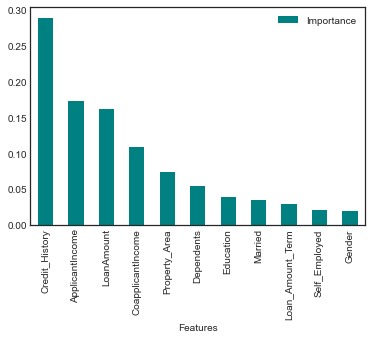

In [49]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

# Machine Learning Model for Classification With Evaulution metrics

In [50]:
def classify(model,X,Y):
    X_test,X_train,Y_train,Y_test=train_test_split(X,Y,test_size=.25,random_state=501)
    
    #training the model
    model.fit(X_train,Y_train)
    
    #Predicting the Y_test
    pred=model.predict(X_test)
    
      #classifiction Report 
    classification=classification_report(pred,Y_test)
    print('classification report = ', classification)
    
  
    
    #Accuracy_score
    accuracy=accuracy_score(pred,Y_test)
    print('Accuracy_score ', accuracy)
    
    #cross validation score
    cross_val=(cross_val_score(model,X,Y,cv=5).mean())*100
    print('cross val score', cross_val)
    
    #Result
    print('accuracy - cross val =',accuracy-cross)

In [51]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=112)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

In [52]:
#LogisticRegression
model=LogisticRegression()
classify(model,X,Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.50      0.63       104
           1       0.65      0.91      0.76       107

    accuracy                           0.71       211
   macro avg       0.74      0.70      0.69       211
weighted avg       0.74      0.71      0.69       211

Accuracy Score: 70.61611374407583
Cross Validation Score: 73.93702451394759

Accuracy Score - Cross Validation Score is -3.320910769871759


In [53]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.51      0.60       104
           1       0.63      0.82      0.72       107

    accuracy                           0.67       211
   macro avg       0.68      0.67      0.66       211
weighted avg       0.68      0.67      0.66       211

Accuracy Score: 66.82464454976304
Cross Validation Score: 75.00211327134404

Accuracy Score - Cross Validation Score is -8.177468721581008


In [54]:
# Decision Tree Classifier

model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       104
           1       0.76      0.76      0.76       107

    accuracy                           0.75       211
   macro avg       0.75      0.75      0.75       211
weighted avg       0.75      0.75      0.75       211

Accuracy Score: 75.35545023696683
Cross Validation Score: 75.4797125950972

Accuracy Score - Cross Validation Score is -0.12426235813036612


In [55]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       104
           1       0.78      0.87      0.82       107

    accuracy                           0.81       211
   macro avg       0.81      0.80      0.80       211
weighted avg       0.81      0.81      0.80       211

Accuracy Score: 80.56872037914692
Cross Validation Score: 82.70921386306001

Accuracy Score - Cross Validation Score is -2.1404934839130902


In [56]:
# K Neighbors Classifier

model=KNeighborsClassifier(n_neighbors=15)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.60      0.65       104
           1       0.66      0.77      0.71       107

    accuracy                           0.68       211
   macro avg       0.69      0.68      0.68       211
weighted avg       0.69      0.68      0.68       211

Accuracy Score: 68.24644549763033
Cross Validation Score: 72.63243167089321

Accuracy Score - Cross Validation Score is -4.385986173262879


In [57]:
# Extra Trees Classifier

model=ExtraTreesClassifier()
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       104
           1       0.82      0.82      0.82       107

    accuracy                           0.82       211
   macro avg       0.82      0.82      0.82       211
weighted avg       0.82      0.82      0.82       211

Accuracy Score: 81.99052132701422
Cross Validation Score: 82.35488870104255

Accuracy Score - Cross Validation Score is -0.3643673740283333


In [58]:
# XGB Classifier

model=xgb.XGBClassifier(verbosity=0)
classify(model, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       104
           1       0.77      0.76      0.76       107

    accuracy                           0.76       211
   macro avg       0.76      0.76      0.76       211
weighted avg       0.76      0.76      0.76       211

Accuracy Score: 76.30331753554502
Cross Validation Score: 79.51042547196391

Accuracy Score - Cross Validation Score is -3.2071079364188932


# Hyper Parameter Tuining on best classification ML model

In [59]:
# Choosing Extra Trees Classifier

fmod_param = {'criterion' : ['gini', 'entropy'],
              'n_jobs' : [-2, -1, 1],
              'random_state' : [42, 739, 1000],
              'max_depth' : [0, 15, 30],
              'n_estimators' : [100, 200, 300]
             }


After comparing all the classification models I have selected Extra Trees Classifier as my best model considering the accuracy score (being high) with the cross validation score against it and have listed down the chosen parameters above.

In [60]:
GSCV = GridSearchCV(ExtraTreesClassifier(), fmod_param, cv=5)

In [61]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 15, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-2, -1, 1],
                         'random_state': [42, 739, 1000]})

In [62]:

GSCV.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'n_estimators': 300,
 'n_jobs': -2,
 'random_state': 42}

In [63]:
Final_Model = ExtraTreesClassifier(criterion='entropy', max_depth=30, n_estimators=100, n_jobs=-2, random_state=1000)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (accuracy_score(Y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)

Accuracy score for the Best Model is: 81.04265402843602


# Aoc Roc Curve

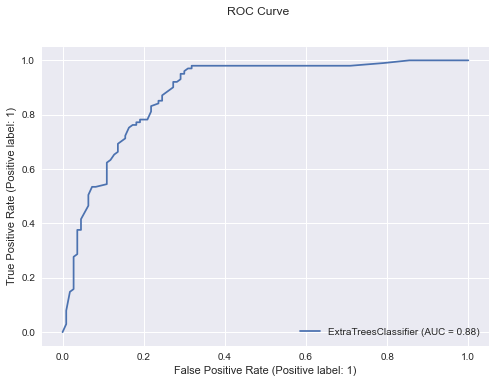

In [64]:
plt.style.use('seaborn')
disp = metrics.plot_roc_curve(Final_Model, X_test, Y_test)
disp.figure_.suptitle("ROC Curve")
plt.show()

# Confusion Matrix

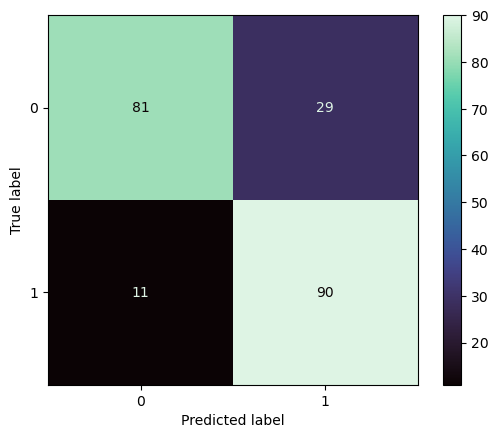

In [66]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(Classifier, X_test, Y_test, cmap='mako')
plt.show()

# Saving the Model

In [67]:
filename='Loan_Application_status_06'
joblib.dump(Final_Model, filename)

['Loan_Application_status_06']

# thanku